In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import numpy as np

In [2]:
# Function that creates unique id for each node

node_ids = set()

def generate_node_id(node_ids):
    new_id = random.randint(1, 1e5)
    while new_id in node_ids:
        new_id = random.randint(1, 1e5)
    node_ids.add(new_id)
    return new_id

In [3]:
# State capture per density_threshold

# By capturing the tree structure at each threshold, 
# you can see how features like connected components emerge, evolve, and disappear.
# This provides insights into the tree's resilience, adaptability, and the significance of its structural features.
# In the case of tree data structure, there is no hole so only connected dots (B_0) is considered

# Depth Threshold

depth_threshold = 3

# Degree/Density Threshold

density_thresholds = list(range(0, 4097, 16)) # [0, 16, 32, ..., 4096]

In [4]:
# Create Octree

def build_octree(data, source_id, depth, density_threshold, betti_0, octree):
    # Base case
    if depth == depth_threshold or len(data) == 0:
        return betti_0, octree
    
    # Calculate the boundaries
    min_x, max_x = data['X'].min(), data['X'].max()
    min_y, max_y = data['Y'].min(), data['Y'].max()
    min_z, max_z = data['Z'].min(), data['Z'].max()

    # Calculate midpoints
    mid_x = (max_x + min_x) / 2
    mid_y = (max_y + min_y) / 2
    mid_z = (max_z + min_z) / 2

    # The eight octants in 3D space
    subdivisions = [
        (data['X'] <= mid_x) & (data['Y'] <= mid_y) & (data['Z'] <= mid_z),
        (data['X'] <= mid_x) & (data['Y'] <= mid_y) & (data['Z'] > mid_z),
        (data['X'] <= mid_x) & (data['Y'] > mid_y) & (data['Z'] <= mid_z),
        (data['X'] <= mid_x) & (data['Y'] > mid_y) & (data['Z'] > mid_z),
        (data['X'] > mid_x) & (data['Y'] <= mid_y) & (data['Z'] <= mid_z),
        (data['X'] > mid_x) & (data['Y'] <= mid_y) & (data['Z'] > mid_z),
        (data['X'] > mid_x) & (data['Y'] > mid_y) & (data['Z'] <= mid_z),
        (data['X'] > mid_x) & (data['Y'] > mid_y) & (data['Z'] > mid_z),
    ]

    # We are reaching further depth
    depth += 1

    for subdivision in subdivisions:
        filtered_data = data[subdivision]
        
        num_points_in_box = len(filtered_data)
        
        target_id = generate_node_id(node_ids)
        
        # Create box/octant to hold each piece of data
        box = [num_points_in_box, depth, source_id, target_id]
        
        # Create box/octant if pass density threshold
        if num_points_in_box > density_threshold:
            octree.append(box)
            betti_0, octree = build_octree(filtered_data, target_id, depth, density_threshold, betti_0, octree)
        else:
            betti_0 += 1

    return betti_0, octree

### $Betti_0$ - Why Do We Need to Examinine It?

**Why examine change in $Betti_0$ with across density thresholds?**

1. Analyze how tree data structure's topplogy evolves as a condition (i.e., density thresholds) is applied 

2. Understand the shape of the input data across scales - provides insights into the data structure's resilience, adaptability, and the significance of its structural features

3. Why only $Betti_0$ is examined - tree data structures don't create loop

4. Why density thresholds? - maybe to provide insights to customize tree data structure (e.g., the greater the density threshold the less data a tree data structure stores yet the faster that data structure is created; the problem is - does it preserve the original features of the input data?)

**Next Steps**

1. Visualize which features of the input data are robust across a range of conditions (i.e., different density thresholds)

2. Understand how well a tree structure adapts to varying densities

3. Build Speed across Density Thresholds (Zhonghao)

4. Octree vs. K-D Tree

### $Betti_0$ Change in House Point Clouds Across Octree Density Thresholds

In [5]:
# Read the data for House Random

data_random = pd.read_csv('data/House/csv/random/house_random.csv', sep=',')[['X', 'Y', 'Z']]
house_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_random_betti_0s.append(betti_0)

In [ ]:
# Read the data for House Spatial

data_spatial = pd.read_csv('data/House/csv/spatial/house_spatial.csv', sep=',')[['X', 'Y', 'Z']]
house_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [6]:
var_house_random = np.var(np.array(house_random_betti_0s))
var_house_spatial = np.var(np.array(house_spatial_betti_0s))

print(var_house_random, var_house_spatial)

1198.955623855017 2093.068085815078


### Wasserstein Distance Between the Two Distributions

In [7]:
was_dis_house = wasserstein_distance(house_random_betti_0s, house_spatial_betti_0s)
print(was_dis_house)

6.385214007782104


### $Betti_0$ Change in Tree Point Clouds Across Octree Density Thresholds

In [8]:
# Read the data for Tree Random

data_random = pd.read_csv('data/Tree/csv/random/tree_random.csv', sep=',')[['X', 'Y', 'Z']]
tree_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_random_betti_0s.append(betti_0)

In [ ]:
# Read the data for Tree Spatial

data_spatial = pd.read_csv('data/Tree/csv/spatial/tree_spatial.csv', sep=',')[['X', 'Y', 'Z']]
tree_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [9]:
var_tree_random = np.var(np.array(tree_random_betti_0s))
var_tree_spatial = np.var(np.array(tree_spatial_betti_0s))

print(var_tree_random, var_tree_spatial)

1757.931293433663 1733.9757452800188


### Wasserstein Distance Between the Two Distributions

In [10]:
was_dis_tree = wasserstein_distance(tree_random_betti_0s, tree_spatial_betti_0s)
print(was_dis_tree)

0.9066147859922182


### $Betti_0$ Change in Light Pole Point Clouds Across Octree Density Thresholds

In [11]:
# Read the data for Light Pole Random

data_random = pd.read_csv('data/LightPole/csv/random/lightpole_random.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    lightpole_random_betti_0s.append(betti_0)

In [ ]:
# Read the data for Light Pole Spatial

data_spatial = pd.read_csv('data/LightPole/csv/spatial/lightpole_spatial.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = build_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    lightpole_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [12]:
var_lightpole_random = np.var(np.array(lightpole_random_betti_0s))
var_lightpole_spatial = np.var(np.array(lightpole_spatial_betti_0s))

print(var_lightpole_random, var_lightpole_spatial)

880.8675680176841 979.5818256143164


### Wasserstein Distance Between the Two Distributions

In [13]:
was_dis_lightpole = wasserstein_distance(lightpole_random_betti_0s, lightpole_spatial_betti_0s)
print(was_dis_lightpole)

1.8754863813229592


### Visualizations of $Betti_0$ Change For All Input Data

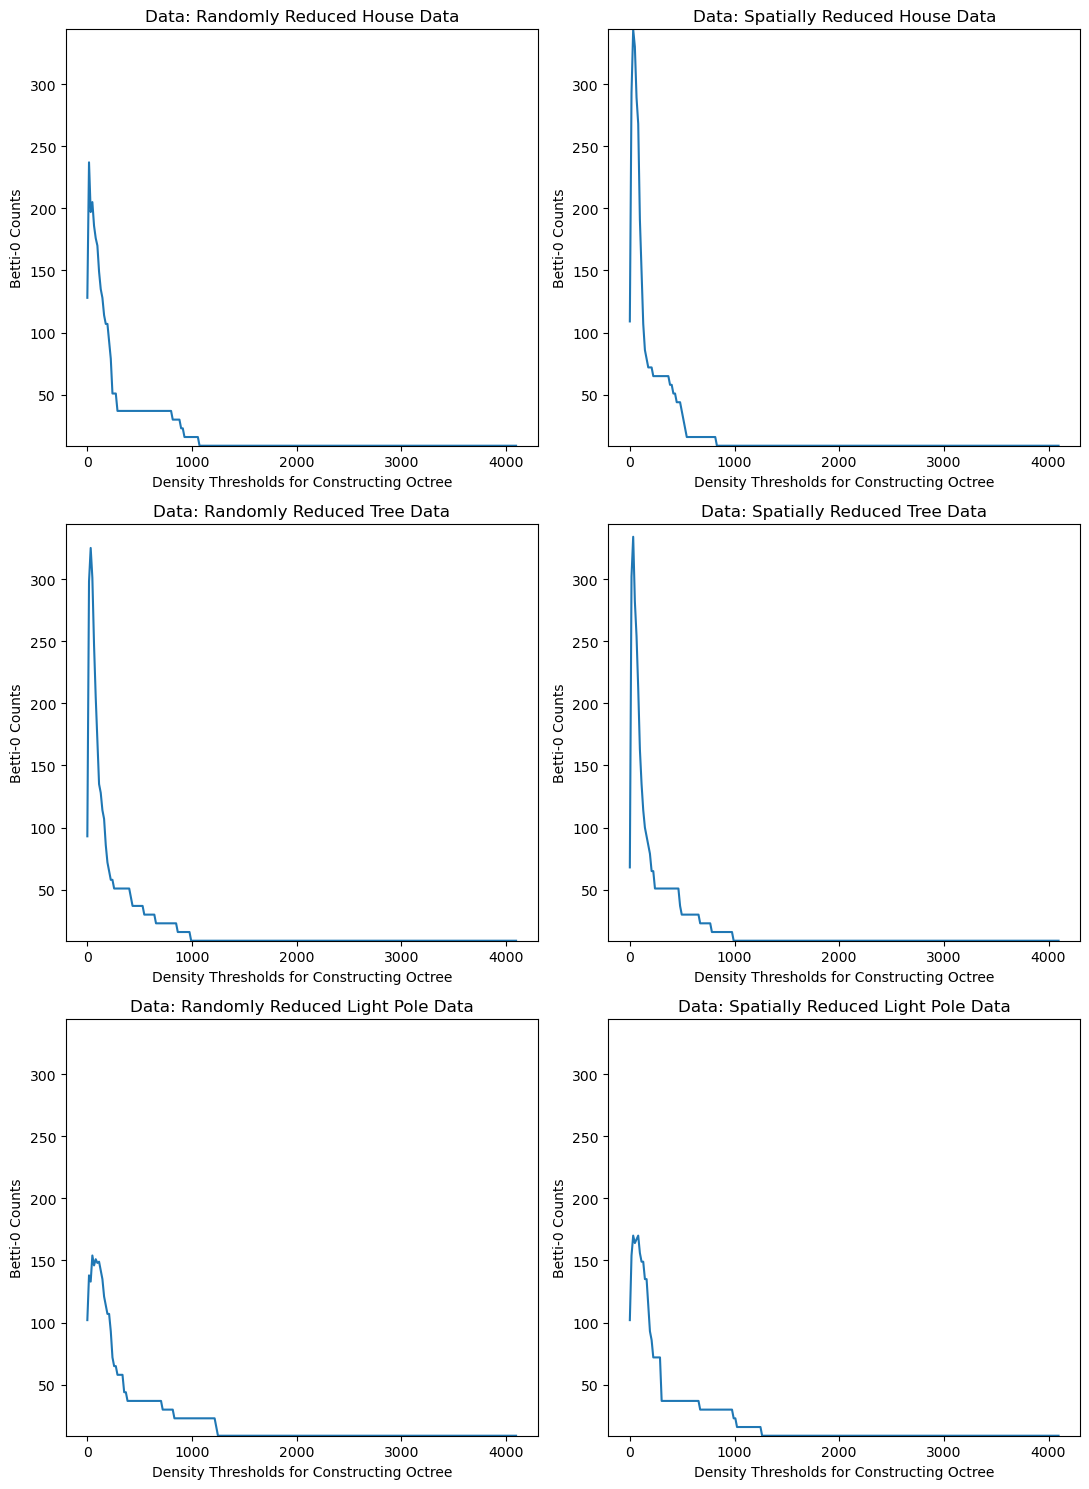

In [19]:
# Determine the global min and max y-values

min_val = min([min(house_random_betti_0s), min(house_spatial_betti_0s), \
           min(tree_random_betti_0s), min(tree_spatial_betti_0s), \
           min(lightpole_random_betti_0s), min(lightpole_random_betti_0s)])

max_val = max([max(house_random_betti_0s), max(house_spatial_betti_0s), \
           max(tree_random_betti_0s), max(tree_spatial_betti_0s), \
           max(lightpole_random_betti_0s), max(lightpole_random_betti_0s)])

# Create plot

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 15))

# Plot for House Random
axs[0,0].plot(density_thresholds, house_random_betti_0s)
axs[0,0].set_xlabel('Density Thresholds for Constructing Octree')
axs[0,0].set_ylabel('Betti-0 Counts')
axs[0,0].set_ylim(min_val, max_val)
axs[0,0].set_title('Data: Randomly Reduced House Data')

# Plot for House Spatial
axs[0,1].plot(density_thresholds, house_spatial_betti_0s)
axs[0,1].set_xlabel('Density Thresholds for Constructing Octree')
axs[0,1].set_ylabel('Betti-0 Counts')
axs[0,1].set_ylim(min_val, max_val)
axs[0,1].set_title('Data: Spatially Reduced House Data')

# Plot for Tree Random
axs[1,0].plot(density_thresholds, tree_random_betti_0s)
axs[1,0].set_xlabel('Density Thresholds for Constructing Octree')
axs[1,0].set_ylabel('Betti-0 Counts')
axs[1,0].set_ylim(min_val, max_val)
axs[1,0].set_title('Data: Randomly Reduced Tree Data')

# Plot for Tree Spatial
axs[1,1].plot(density_thresholds, tree_spatial_betti_0s)
axs[1,1].set_xlabel('Density Thresholds for Constructing Octree')
axs[1,1].set_ylabel('Betti-0 Counts')
axs[1,1].set_ylim(min_val, max_val)
axs[1,1].set_title('Data: Spatially Reduced Tree Data')

# Plot for Light Pole Random
axs[2,0].plot(density_thresholds, lightpole_random_betti_0s)
axs[2,0].set_xlabel('Density Thresholds for Constructing Octree')
axs[2,0].set_ylabel('Betti-0 Counts')
axs[2,0].set_ylim(min_val, max_val)
axs[2,0].set_title('Data: Randomly Reduced Light Pole Data')

# Plot for Light Pole Spatial
axs[2,1].plot(density_thresholds, lightpole_spatial_betti_0s)
axs[2,1].set_xlabel('Density Thresholds for Constructing Octree')
axs[2,1].set_ylabel('Betti-0 Counts')
axs[2,1].set_ylim(min_val, max_val)
axs[2,1].set_title('Data: Spatially Reduced Light Pole Data')

plt.tight_layout()
plt.show()

### Comparison Among Z-Score Normalized Varainces

In [15]:
var = np.array([var_house_random, var_house_spatial, \
                var_tree_random, var_tree_spatial, \
                var_lightpole_random, var_lightpole_spatial])
var_normal = (var - np.mean(var)) / np.std(var)

print(abs(var_normal))

[0.54136592 1.46067405 0.71025698 0.65661724 1.25360854 1.03257383]


| Input Data |Variances|
| -| - |
| House (Random)  | 0.54136592  |
| House (Spatial) | 1.46067405  |
| Tree (Random) | 0.71025698  |
| Tree (Spatial) | 0.65661724  |
| Light Pole (Random) | 1.25360854  |
| Light Pole (Spatial) | 1.03257383  |

### Comparison Among Z-Score Normalized Wasserstein Distances

In [16]:
was_dis = np.array([was_dis_house, was_dis_tree, was_dis_lightpole])

was_dis_normal = (was_dis - np.mean(was_dis)) / np.std(was_dis)

print(abs(was_dis_normal))

[1.39466675 0.9002582  0.49440855]


| Input Data |Normalized Wasserstein Distance|
| -| - |
| House | 1.39466675  |
| Tree | 0.9002582  |
| Light Pole | 0.49440855 |

# What do these numbers potentially show?

1. Comparatively Greater Variance difference between House(Random) and House(Spatial) data

2. Subsample choice matters for reducing House Data

3. **Spatial subsampling** preserves more of the original house structure.<br>That being said: Spatial subsampling method **usually recommended** for storing house point cloud data **if one wants to presserve a very well structured house point cloud**. Please be awared that the spatial subsampling method is **slow**. 

4. Interestingly, random and spatial subsampling methods works comparatively well for both Tree (comparatively ill structured) and Light Pole (comparatively well structured) data. That being said: **random subsampling method** in these two cases is **usually recommended** since it is a lot faster.

# What do these numbers further show?

**House**

1. Comparatively greater variance difference among the two house topo graphs. 

2. Subsample choice usually matters for representing House Data - because we can't control how random subsampling method may sometimes distord the original structure.

3. Spatial Subsampling method usually preserves more of the original house structure, although it is slower.

4. Wasserstein distance between the two topological graphs is the largest - probably because how the two subsampling methods result in very different structured data, so they aren't similar. 

5. Which part of the house got discarded at the early stage when density threshold is low? The non-roof part. Why? Not enough points in most of the octants to pass the density threshold. So what? If one wants to search for any point near the base of the house, one would not find them if the density threshold is set to be too high and if the house structure aren't preserved well.


**Light Pole & Tree**

1. Wasserstein distance between of the two light pole point cloud data is the shortest. Why? The very "obvious" and organized geometry of light poles makes their structure hard to get destroyed in either random or spatial subsampling.

2. The Wasserstein distance between two tree data sets is comparatively long (2 times of that of light pole data). Why? Not all leaf areas have an equal density of points, so some leaf areas are discarded by the density threshold earlier, and that makes a big(?) difference between storing two kinds of tree data in an octree.

3. However, very interestingly, if one takes a look at the vidualizations of the two tree point cloud, that produced by random subsampling method looks more "tree-like".

4. Due to the slender feature of the light pole in addition to the inclusion of the base/ground part in its point cloud data file, more points are concentrated in fewer octants of the octree. So, a larger portion of the point cloud that construct the significant part of the light pole (i.e., what construct its slender feature) are going to get destroyed first with a relatively high density threshold and with a base/ground area in the input point cloud file. 

5. Which part of the light pole or tree got discarded at the early stage when density threshold is low? The foilage part (tree) and the pole part (lighe pole). Why? Low density. So what? Unfortunately octree gives equal attention to all of its octant without considering the actual density of those octants, so one has to be aware that if the density threshold is too high for storing any point cloud object with one part that is obviously less dense than the others, then that part with less density is going to get discarded first. 

### Export Files for Visualization in Gephi

In [17]:
# octree_df = pd.DataFrame(octree, columns=['Degree', 'Depth', 'Source', 'Target'])

# # Edge
# # Source,Target,Type

# octree_df_edge = octree_df[['Source', 'Target']].copy()
# octree_df_edge['Type'] = 'Directed'

# # Node
# # Id,Degree(num_point),Depth

# octree_df_node = octree_df[['Target', 'Degree', 'Depth']]
# octree_df_node = octree_df_node.rename(columns={'Target': 'Id'})
# octree_df_node.loc[len(octree_df_node)] = {'Id': 0, 'Degree': 4096, 'Depth': 0} # append root node

# # export CSV

# octree_df_edge.to_csv('edge.csv', index = False)
# octree_df_node.to_csv('node.csv', index = False)